# ML3. Логистическая регрессия

Логистическая функция хорошо приближает значения $(0, 1)$:

$ logistic(z)=\frac{P}{1+e^{-kz}} $

На практике мы используем частный случай логистической функции — **сигмоида**:

$ \sigma (z)=\frac{1}{1+e^{-z}} $

Сигмоида принимает значения от 0 до 1. В контексте классификации это значение можно трактовать как вероятность того, что объект принадлежит одному из двух классов. Тогда **уравнение сигмоиды** для задачи логистической регрессии будет выглядеть так:

$ \sigma (x;\beta )=\frac{1}{1+e^{-\dot{\beta} x}} $

Для нахождения **оптимального значения** параметров нужно решить следующую задачу оптимизации:

$ min\sum_{1}^{i}ln(1+e^{-y_i\dot{\beta }x}) $

Решать её можно **градиентным спуском**.

Когда мы получаем на выходе модели нули и единицы, мы можем использовать обычные **метрики** для классификации — *Accuracy, f1 score* и другие. Если мы хотим посчитать **ошибку для вероятностей**, которые возвращает сигмоида, можно воспользоваться *logloss*:

$ logloss(y_{true}, y_{pred})=-y_{true}ln y_{pred}-(1-y_{true})ln(1-y_{pred}) $

То же самое для нескольких классов:

- $y_{true_-ij}$ - бинарная переменная. 1 — если пример *i* имеет класс *j*, иначе равно 0.
- $y_{pred_-ij}$ - вероятность того, что пример *i* имеет класс *j*, берётся из модели.

**Softmax** — обобщение сигмоиды для многомерного случая. Функция преобразует вектор *z* размерности в вектор той же размерности, где каждая координата полученного вектора представлена вещественным числом в интервале $[0,1]$ и сумма координат равна 1.

$ \sigma (z)_i=\frac{e^{z_i}}{\sum_{k=1}^{K}e^{z_k}} $

## Задание 5.3

Посчитайте *logloss* для данных в таблице (без нормализации). Укажите число с точностью до сотых:

| Предсказанное значение | Истинное значение |
|------------------------|-------------------|
| 0.2                    | 0                 |
| 0.8                    | 0                 |
| 1                      | 1                 |
| 0.6                    | 1                 |

In [1]:
from sklearn.metrics import log_loss

In [3]:
import numpy as np

In [12]:
def logloss(y_true, y_pred):
    return -y_true * np.log(y_true) - (1 - y_true) * np.log(1 - y_pred)

In [18]:
y_pred = np.array([0.2, 0.8, 1, 0.6])
y_test = np.array([0, 0, 1, 1])

log_loss(y_test, y_pred) * 4

2.343407087514302

## Задание 5.4

Посчитайте *logloss* для данных в таблице. Необходимо найти среднюю ошибку. Классификация на три класса:

| Предсказанное значение | Истинное значение |
|------------------------|-------------------|
| 0.2, 0.3, 0.5          | 0, 0, 1           |
| 0, 0, 1                | 0, 0, 1           |
| 0.1, 0, 0.9            | 1, 0, 0           |

In [26]:
y_pred = np.array([
    [0.2, 0.3, 0.5],
    [0,     0,   1],
    [0.1,   0, 0.9],
])
y_true = np.array([
    [0, 0, 1],
    [0, 0, 1],
    [1, 0, 0],
])

In [27]:
m = y_true * np.log(y_pred)
m_sum = m[~np.isnan(m)].sum()
llm = -1 / len(y_true) * m_sum
llm

<ipython-input-27-07dbb1c021a6>:1: RuntimeWarning: divide by zero encountered in log
  m = y_true * np.log(y_pred)
<ipython-input-27-07dbb1c021a6>:1: RuntimeWarning: invalid value encountered in multiply
  m = y_true * np.log(y_pred)


0.9985774245179969

In [28]:
length, width = y_pred.shape

logloss_multy = 0
for i in range(length):
    for j in range(width):
        if y_true[i,j] == y_pred[i,j]:
            continue
        else:
            logloss_multy += y_true[i,j] * np.log(y_pred[i,j])
logloss_multy *= -(1/length)
logloss_multy

0.9985774245179969

## 6. Логистическая регрессия. Практика

Реализуем логистическую регрессию. Начнём с импорта библиотеки:

In [85]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt

В случае с логистической регрессией мы можем использовать только **градиентный спуск**, так как нет явного матричного способа найти оптимальные коэффициенты. В качестве функции потерь будем использовать **бинарную кросс-энтропию**, *Log Loss*. Она записывается так:

$ L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))) $

Градиент ошибки:

$ \nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i} $

Будем использовать другой датасет с задачей **классификации**, где нужно определить зарплату меньше и больше определённого значения. Убираем в данных лишние признаки, конвертируем целевой столбец в бинарные значения и нормализуем данные.

Реализуем функцию `sigmoid` и функцию, вычисляющую **градиент бинарной кросс-энтропии:**

In [29]:
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

Сделаем предсказания на тренировочной выборке и посчитаем значение метрики *accuracy* и *F1 score*:

In [39]:
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

NameError: name 'X' is not defined

Мы уже знаем, что этой выборке нельзя доверять, поэтому разбиваем данные и оптимизируем:

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

NameError: name 'train_test_split' is not defined

Результат практически тот же. Отрисуем *ROC-кривую*, посчитаем её значения и значение площади под кривой *AUC*.

Для борьбы с **переобучением** добавим **регуляризацию**. Обернём линейную регрессию в **класс:**

In [32]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

Проделаем ту же операцию с логистичекой регрессией:

In [33]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

Избавлимся от лишних признаков, нормализуем данные. С переобучением боремся с помощью **регуляризации**.

$ \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2} $

После добавления регуляризации функция ошибки **линейной регрессии** будет выглядеть так:

$ L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2} $

А её градиент по параметру $\theta$:

$ \nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} $

Функция ошибки для **логистической регрессии** в случае бинарной классификации с регуляризатором записывается так:

$ L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2} $

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах Adult Income (файл также можно скачать из [открытого источника](https://archive.ics.uci.edu/ml/datasets/Adult)). Далее сделаем необходимую предобработку:

In [127]:
df = pd.read_csv('./data/adult.data', names=[
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'salary',
])

In [128]:
df['salary'] = (df['salary'] != ' <=50K').astype('int32')
df.drop('native-country', axis=1, inplace=True)

df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0


In [130]:
cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features = df[cols].values
mu = features.mean(axis=0)
sigma = features.std(axis=0)
norm_features = (features - mu) / sigma

df.loc[:, cols] = norm_features

In [131]:
df_train = pd.get_dummies(df, columns=[
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
])
df_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.639741,0.746039,-0.145920,-0.21666,-0.197409,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
32557,0.103983,-0.335433,-0.420060,-0.145920,-0.21666,-0.035429,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
32558,1.423610,-0.358777,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
32559,-1.215643,0.110960,-0.420060,-0.145920,-0.21666,-1.655225,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


## Задание 6.1

Постройте модель логистической регрессии при помощи `sklearn`. Используйте параметры по умолчанию, обучите на всей выборке и посчитайте *F1 score*.

In [162]:
x = df_train.drop('salary', axis=1).values
x = np.hstack([np.ones((x.shape[0], 1)), x])
y = df_train['salary'].values

In [163]:
solver = LogisticRegression(max_iter=100)
solver.fit(x, y)

y_pred = solver.predict(x)

f1_score(y, y_pred)

/data/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6616594131686088

## Задание 6.2

Посчитайте *confusion matrix* для классификатора из задачи 3.6.1. Для получения матрицы можно воспользоваться методом `sklearn.metrics.confusion_matrix(y_true, y_pred)`, либо посчитать каждый элемент вручную.

|            | 1 (predicted)  | 0 (predicted)  |
|------------|----------------|----------------|
| 1 (actual) | True Positive  | False Negative |
| 0 (actual) | False Positive | True Negative  |

Введите значения получившейся матрицы в соответствующие ячейки:

In [164]:
from sklearn.metrics import confusion_matrix

In [165]:
m = confusion_matrix(y, y_pred)
m

array([[23028,  1692],
       [ 3128,  4713]])

## Задание 6.3

Постройте *ROC-кривую* и посчитайте $ROC-AUC$ для классификатора из задачи 3.6.1.

In [167]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

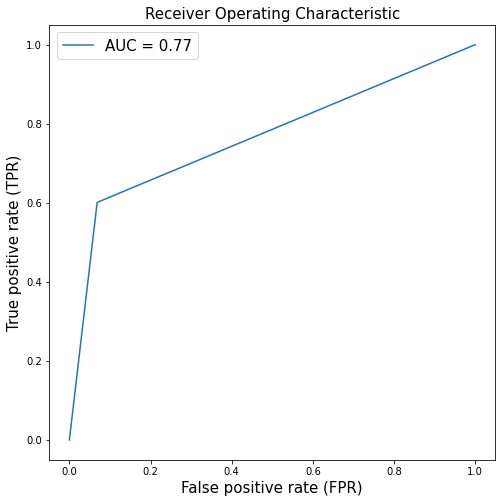

In [172]:
calc_and_plot_roc(y, y_pred)

## Задание 6.4

Переберите коэффициенты *l2-регуляризации* от 0.01 до 1 с шагом 0.01 и определите, на каком из них модель логистической регрессии из *sklearn* даёт наибольший *F1 score*.

In [162]:
x = df_train.drop('salary', axis=1).values
x = np.hstack([np.ones((x.shape[0], 1)), x])
y = df_train['salary'].values

In [183]:
np.arange(0.01, 1, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [188]:
# solver = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0)

scores = []

for c in np.arange(0.01, 1, 0.01):
    solver = LogisticRegression(solver='newton-cg', penalty='l2', C=c)
    solver.fit(x, y)
    y_pred = solver.predict(x)
    score = f1_score(y, y_pred)
    scores.append((c, score))

In [187]:
sorted(scores, key=lambda x: x[1], reverse=True)[0]

(0.65, 0.6624087591240876)

## Задание 6.5

Замените в столбце `native-country` страны, у которых меньше ста записей, на `other`, поменяйте этот столбец на *dummy-переменные*, обучите классификатор на всей выборке и посчитайте *F1 score*.

In [190]:
df = pd.read_csv('./data/adult.data', names=[
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'salary',
])

df['salary'] = (df['salary'] != ' <=50K').astype('int32')

cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features = df[cols].values
mu = features.mean(axis=0)
sigma = features.std(axis=0)
norm_features = (features - mu) / sigma
df.loc[:, cols] = norm_features

In [212]:
country_counts = df['native-country'].value_counts()
x = country_counts[country_counts < 100]
df['native-country'] = df['native-country'].replace(x.index, 'other')

In [213]:
df_train = pd.get_dummies(df, columns=[
    'native-country', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'
])
df_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,native-country_ ?,native-country_ Canada,native-country_ El-Salvador,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.639741,0.746039,-0.145920,-0.21666,-0.197409,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
32557,0.103983,-0.335433,-0.420060,-0.145920,-0.21666,-0.035429,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
32558,1.423610,-0.358777,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
32559,-1.215643,0.110960,-0.420060,-0.145920,-0.21666,-1.655225,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [216]:
x = df_train.drop('salary', axis=1).values
x = np.hstack([np.ones((x.shape[0], 1)), x])
y = df_train['salary'].values

solver = LogisticRegression(solver='newton-cg')
solver.fit(x, y)

y_pred = solver.predict(x)
f1_score(y, y_pred)

0.6632051641874824